<h1 align=center><font size = 10> Capstone: Getting Outdoors with the Family </font></h1>

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction and Problem Statement. <a name="introduction"></a>

As Covid-19 stay-at-home orders persist in Seattle(1), families are getting more than a little antsy cooped up inside—which makes outdoor activities a great way to get a change of scenery. Moreover, if you choose your destination wisely, it can seriously de-stress you. In a 2020 study published in Environment and Behavior, people experiencing chronic life stress who spent 40 minutes walking outside in nature experienced greater decreases in the stress hormone cortisol than those who walked either indoors on a treadmill or who watched nature programming on TV for the same amount of time(2).  
As the restrictions include a ban on  non-essential travel, neighborhood parks provide a way to get outside, without travelling too far from home.
The ideal parks should have a range of activities for the family, and be close to restaurants for getting take-out. 
This project will provide an analysis of Seattle parks based on their available amenities and nearby restaurants. The nearby restaurants will further be profiled based on the number and types of restaurants present in an area around the parks.
 
1.	<a href="https://www.governor.wa.gov/sites/default/files/SafeStartWA_4May20_1pm.pdf"> Official Governor Inslee Stay at home order: </a>

2.	  <a href="https://doi.org/10.1177/0013916518800798 ">Olafsdottir, G., Cloke, P., Schulz, A., van Dyck, Z., Eysteinsson, T., Thorleifsdottir, B., & Vögele, C. (2020). Health Benefits of Walking in Nature: A Randomized Controlled Study Under Conditions of Real-Life Stress. Environment and Behavior, 52(3), 248–274. </a>


## Data and Tools.<a name="data"></a>
To identify suitable candidate park locations, we use two data sources: Data.gov and Foursquare, listed below. The Data.gov obtained dataset includes a listing of Seattle parks within city limits, including their individual latitude/longitude and amenities(eg: boat ramps, play structures, soccer fields…). This will be used to both geolocate the parks, and identify the parks with the largest variety of different amenities.  The geolocation will be used as input for Foursquare to obtain nearby restaurant information and generate the map. This will ahelp families select their park destination. 

1.	<a href="https://catalog.data.gov/dataset/seattle-parks-and-recreation-parks-features"> Data.gov: Seattle Parks and Recreation Park Features, including park amenities </a>
2.	<a href="https://developer.foursquare.com/places"> Foursquare developer places database which enables searches of restaurants within walking distance of a park, and classification of types of food </a>

### Install and Load all the libraries and credential information needed

In [1]:
### One time install of necessary Libraries, remarked out for subsequent runs

#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!pip install pyproj
print('Everything installed')

Everything installed


In [2]:
import requests # library to handle requests
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from pyproj import Geod # Library for measuring distances
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# import k-means from clustering stage
from sklearn.cluster import KMeans
import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


import folium # plotting library


print('Libraries imported.')

Libraries imported.


In [3]:
### Define our central location: Queen Anne Neighborhood, the area of interest to our group of families. 
address = '500 3rd Ave W, Seattle, WA' #This is the center of the Queen Anne neighborhood, 
latitude=47.6236325
longitude=-122.36024895


In [4]:
###Foursquare Credentials and Version: Removed for purposes of publishing: If you want to replicate, please enter your own credentials.

CLIENT_ID = 'TF33HK1LL3NCC2LYCV5K33RJSEB2CLURMMKCOVPWEZBEND5N' # your Foursquare ID
CLIENT_SECRET = 'FILL0VWTZSUWTZTN3RDS2IU1F0ADAOOJYP1ITMSOJCXEOZBI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30

### Load the pre-downloaded file of Seattle Parks and Recreation from Data.gov and do a bit of clean-up
Load data from data.gov csv file, remove un-necessary columns


In [5]:
seattle_parks = pd.read_csv('Seattle_Parks_And_Recreation_Parks_Features.csv')
seattle_parks.head(3) # Show the top few rows

,PMAID,Name,Alt_Name,xPos,yPos,Feature_ID,hours,Feature_Desc,CHILD_DESC,FIELD_TYPE,YOUTH_ONLY,LIGHTING,Location 1
0,281,12th and Howe Play Park,NaN,-122.372985,47.636097,22,6 a.m. - 10 p.m.,Play Area,Play Area,NaN,False,False,"1200 W Howe St\n(-122.372985, 47.636097)"
1,4159,12th Ave S Viewpoint,NaN,-122.317765,47.577953,34,6 a.m. - 10 p.m.,View,NaN,NaN,False,False,"2821 12TH Ave S\n(-122.317765, 47.577953)"
2,4010,14th Ave NW Boat Ramp,NaN,-122.373536,47.660775,7,4 a.m. - 11:30 p.m.,Boat Launch (Hand Carry),NaN,NaN,False,False,"4400 14th Ave NW\n(-122.373536, 47.660775)"


In [6]:
#Rename the columns from X and Y positions in the GeoFile to Latitude and Longitude
seattle_parks.rename(columns={'xPos':'lng'},inplace=True)
seattle_parks.rename(columns={'yPos':'lat'},inplace=True)
## Remove the NaN locations  
seattle_parks=seattle_parks[seattle_parks['lat'].notna()]
seattle_parks=seattle_parks[seattle_parks['lng'].notna()]
## Remove unnecessary columns
seattle_parks.drop(['PMAID', 'Feature_ID','Alt_Name','CHILD_DESC','LIGHTING','FIELD_TYPE','YOUTH_ONLY','Location 1'], axis=1, inplace=True)
seattle_parks.head(3) # Show the top few rows

,Name,lng,lat,hours,Feature_Desc
0,12th and Howe Play Park,-122.372985,47.636097,6 a.m. - 10 p.m.,Play Area
1,12th Ave S Viewpoint,-122.317765,47.577953,6 a.m. - 10 p.m.,View
2,14th Ave NW Boat Ramp,-122.373536,47.660775,4 a.m. - 11:30 p.m.,Boat Launch (Hand Carry)


In [7]:
## Create Distance measurement function
wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

#Get distance between pairs of lat-lon points
def Distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist

## Methodology <a name="methodology"></a>


### Stage 1 - Business Understanding
As stated in the previous section of this report, our main goal is to find nearby outdoor parks in Seattle with a range of activities to enjoy. Our fictional sponsor is a Queen Anne neighborhood parent group looking for places to go with their kids in Seattle right now.

### Stage 2 - Analytic Approach
#### To decide the ideal parks, we must identify the key factors which drive the attractiveness for families. Factors include:
##### 1)	Variety of available activities at the park
##### 2)	Number of activities at the park
##### 3)	Types of nearby restaurants 
##### 4)	Proximity to nearby restaurants
##### 5)	Variety of nearby restaurants


### Stage 3 - Data Requirements
As stated in the Data & Tools section, the data requirements for this research are the park and restaurant information in Seattle. Consequently, information about the restaurants (cuisine and geographical coordinates) are also necessary.


## Analysis.<a name="#analysis"></a>


### First, let's analyze the parks themselves

In [8]:
print('There are {} parks '.format(len(seattle_parks['Name'].unique())), 'which include {} unique categories of amenities .'.format(len(seattle_parks['Feature_Desc'].unique())))
print('The amenities include:', *seattle_parks['Feature_Desc'].unique(), sep='\n- ')

There are 288 parks  which include 66 unique categories of amenities .
The amenities include:
- Play Area
- View
- Boat Launch (Hand Carry)
- Boat Launch (Motorized)
- Waterfront
- Paths
- Fire Pit
- Paths (ADA Compliant)
- Picnic Sites
- Rental Facility
- Restrooms
- Restrooms (ADA Compliant)
- Fishing
- Tennis Court (Outdoor)
- Green Space
- Woods
- Adult Fitness Equipment
- Play Area (ADA Compliant)
- Pesticide Free
- Skatepark
- Wading Pool or Water Feature
- Historic Landmark
- P-Patch Community Garden
- Weddings and Ceremonies
- Dog Off Leash Area
- Community Building
- Garden
- Bike Trail
- Baseball/Softball
- Soccer
- Tennis Lights
- Environmental Learning Center
- Hiking Trails
- Creek
- Picnic Sites (ADA Compliant)
- Basketball (Half)
- Basketball (Full)
- Tennis Backboard (Outdoor)
- Track
- Community Center
- Decorative Fountain
- Golf
- Guarded Beach
- Pool (Indoor)
- Cricket
- Lawn Bowling
- Bike Polo
- Football
- Skatespot
- Model Boat Pond
- Boat Moorage
- Horseshoe Pit

#### Which parks have the most options?

There are only 14 parks with more than 15 amenities, that's 4.861111111111112%


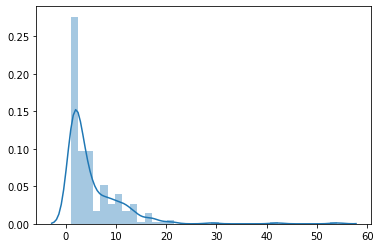

In [9]:
amenitycounts=seattle_parks.groupby('Name').size().sort_values(ascending=False)
sns.distplot(amenitycounts);
print(f"""There are only {len(amenitycounts[amenitycounts>=15.0])} parks with more than 15 amenities, that's {len(amenitycounts[amenitycounts>=15.0])/len(amenitycounts)*100}%""")

In [10]:
#This is the list of the 14 parks which have more than 15 amenities each. 
nbrhoods_used = amenitycounts[amenitycounts>=15.0].index 
seattle_parks_filtered = seattle_parks[seattle_parks.Name.isin(nbrhoods_used)]
seattle_dblfltr=seattle_parks_filtered[['Name','lng','lat']].drop_duplicates()
print('The 14 parks which have more than 15 amenities each include:', *seattle_dblfltr['Name'], sep='\n- ')

The 14 parks which have more than 15 amenities each include:
- Carkeek Park
- Discovery Park
- Jefferson Park
- Golden Gardens Park
- Green Lake Park
- Judkins Park and Playfield
- Lincoln Park
- Mt. Baker Park
- Seward Park
- Warren G. Magnuson Park
- Woodland Park
- Meadowbrook Playfield
- Magnolia Playfield
- Hiawatha Playfield


### Now to find Restaurants around each

In [11]:
#Used for initial generation of full restaurant dataframe: Subsequently Commented Out once file was written

##seattle_restaurants = getNearbyRestaurants(names=seattle_apf['Name'],
##                                    latitudes=seattle_apf['lat'],
##                                    longitudes=seattle_apf['lng']
##                                   )
##seattle_restaurants.to_csv('seattlepark_restaurant.csv', index=False)#Save to File for later re-opening rather than regenerating each time

#Used for initial generation of 14 park restaurant dataframe: Subsequently Commented Out once file was written

##seattle_restaurants15park = getNearbyRestaurants(names=seattle_dblfltr['Name'],
##                                    latitudes=seattle_dblfltr['lat'],
##                                    longitudes=seattle_dblfltr['lng']
##                                   )
##seattle_restaurants15park.to_csv('seattlepark_restaurant_15park.csv', index=False)#Save to File for later re-opening rather than regenerating each time

In [12]:
#Read Files from previously generated restaurant list dataframes
seattle_restaurants = pd.read_csv('seattlepark_restaurant.csv')
seattle_restaurants15 = pd.read_csv('seattlepark_restaurant_15park.csv')

In [13]:
## Add column of distance of Restaurants from the parks
new_column = [] 
for index,row in seattle_restaurants.iterrows():
  lat1 = row['ParkLatitude'] #first row of location.lat column here
  lon1 = row['ParkLongitude'] #first row of location.long column here
  lat2 = row['VenueLatitude'] #second row of location.lat column here
  lon2 = row['VenueLongitude'] #second row of location.long column here
  value = Distance(lat1, lon1, lat2, lon2)  #get the distance
  new_column.append(value)   #append the empty list with distance values

seattle_restaurants['Distance']=new_column
seattle_restaurants.head(10) #Display the top 10 rows of the dataframe, as a visualized example.

,Park,ParkLatitude,ParkLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory,Distance
0,12th and Howe Play Park,47.636097,-122.372985,Fuji Bakery,47.628231,-122.370457,Bakery,894.991699
1,12th and Howe Play Park,47.636097,-122.372985,S & L,47.639562,-122.364777,Bakery,727.208671
2,12th and Howe Play Park,47.636097,-122.372985,How To Cook A Wolf,47.638649,-122.356932,Italian Restaurant,1239.285194
3,12th and Howe Play Park,47.636097,-122.372985,Taco Time,47.629591,-122.371722,Taco Place,729.560773
4,12th and Howe Play Park,47.636097,-122.372985,Bite Box,47.639423,-122.361439,Bistro,943.157304
5,12th and Howe Play Park,47.636097,-122.372985,Homegrown,47.638472,-122.357048,Sandwich Place,1226.420285
6,12th and Howe Play Park,47.636097,-122.372985,Eden Hill,47.638698,-122.357034,Restaurant,1233.089654
7,12th and Howe Play Park,47.636097,-122.372985,Mezcaleria Oaxaca,47.637899,-122.357230,Mexican Restaurant,1200.807354
8,12th and Howe Play Park,47.636097,-122.372985,Caffe Ladro,47.638644,-122.357090,Café,1227.565810
9,12th and Howe Play Park,47.636097,-122.372985,Pagliacci Pizza,47.648727,-122.378492,Pizza Place,1463.983421


In [14]:
print('The restaurant types near parks include:', *seattle_restaurants['VenueCategory'].unique(), sep='\n- ')

The restaurant types near parks include:
- Bakery
- Italian Restaurant
- Taco Place
- Bistro
- Sandwich Place
- Restaurant
- Mexican Restaurant
- Café
- Pizza Place
- Donut Shop
- Seafood Restaurant
- Cajun / Creole Restaurant
- Breakfast Spot
- German Restaurant
- Vietnamese Restaurant
- American Restaurant
- Chinese Restaurant
- Food Truck
- French Restaurant
- Greek Restaurant
- Burger Joint
- Korean Restaurant
- Noodle House
- Thai Restaurant
- Japanese Restaurant
- Salad Place
- New American Restaurant
- Irish Pub
- Sushi Restaurant
- Fondue Restaurant
- Mediterranean Restaurant
- Turkish Restaurant
- Spanish Restaurant
- Taiwanese Restaurant
- Diner
- Dumpling Restaurant
- Vegetarian / Vegan Restaurant
- BBQ Joint
- Asian Restaurant
- Cuban Restaurant
- Caribbean Restaurant
- Ethiopian Restaurant
- Hawaiian Restaurant
- Szechuan Restaurant
- Food Court
- Hotpot Restaurant
- Poke Place
- Deli / Bodega
- South American Restaurant
- Bagel Shop
- Fish & Chips Shop
- Creperie
- Wings 

In [15]:
## Add column of distance of Restaurants from the 15 parks
new_column = [] 
for index,row in seattle_restaurants15.iterrows():
  lat1 = row['ParkLatitude'] #first row of location.lat column here
  lon1 = row['ParkLongitude'] #first row of location.long column here
  lat2 = row['VenueLatitude'] #second row of location.lat column here
  lon2 = row['VenueLongitude'] #second row of location.long column here
  value = Distance(lat1, lon1, lat2, lon2)  #get the distance
  new_column.append(value)   #append the empty list with distance values

seattle_restaurants15['Distance']=new_column


### Now to Analyze the kinds of restaurants around the parks

In [16]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_restaurants[['VenueCategory']],
                                prefix="", prefix_sep="")
# add Park column back to dataframe
seattle_onehot['Park'] = seattle_restaurants['Park'] 
# move Park column to the first column
fixed_columns = ['Park'] + [_ for _ in seattle_onehot.columns if _ !='Park']
seattle_onehot = seattle_onehot[fixed_columns]

#Group them for a list of parks with percentages
seattle_grouped1 = seattle_onehot.groupby('Park').mean().reset_index() 


In [17]:
def return_most_common_venues(row, num_top_venues): #Create a function to help sort into the most common restaurant types
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
##Cluster by Restaurant category
###k-means to cluster into 10 clusters
# set number of clusters

kclusters = 5

seattle_grouped_clustering = seattle_grouped1.drop('Park', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 2, 2, 4, 4, 3, 0, 4, 0], dtype=int32)

In [19]:
##Create the dataframe and display top 10 restaurants for each park
num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Park']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [20]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Park'] = seattle_grouped1['Park']
for ind in np.arange(seattle_grouped1.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped1.iloc[ind, :], num_top_venues)


for ind in np.arange(seattle_grouped1.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = \
    return_most_common_venues(seattle_grouped1.iloc[ind, :], num_top_venues)


In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()
seattle_merged = seattle_restaurants

# merge seattle_grouped1 with seattle_restaurants to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Park'), on='Park')


seattle_merged.head()

,Park,ParkLatitude,ParkLongitude,Venue,VenueLatitude,VenueLongitude,VenueCategory,Distance,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,12th and Howe Play Park,47.636097,-122.372985,Fuji Bakery,47.628231,-122.370457,Bakery,894.991699,4,Pizza Place,Thai Restaurant,Mexican Restaurant,Café,Sandwich Place
1,12th and Howe Play Park,47.636097,-122.372985,S & L,47.639562,-122.364777,Bakery,727.208671,4,Pizza Place,Thai Restaurant,Mexican Restaurant,Café,Sandwich Place
2,12th and Howe Play Park,47.636097,-122.372985,How To Cook A Wolf,47.638649,-122.356932,Italian Restaurant,1239.285194,4,Pizza Place,Thai Restaurant,Mexican Restaurant,Café,Sandwich Place
3,12th and Howe Play Park,47.636097,-122.372985,Taco Time,47.629591,-122.371722,Taco Place,729.560773,4,Pizza Place,Thai Restaurant,Mexican Restaurant,Café,Sandwich Place
4,12th and Howe Play Park,47.636097,-122.372985,Bite Box,47.639423,-122.361439,Bistro,943.157304,4,Pizza Place,Thai Restaurant,Mexican Restaurant,Café,Sandwich Place


In [22]:
seattle_merged.shape

(24487, 14)

In [23]:
num_top_venues = 5

for hood in seattle_grouped1['Park']:
    print("----"+hood+"----")
    temp = seattle_grouped1[seattle_grouped1['Park'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)*100
    temp = temp.round({'freq': 0})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----12th Ave S Viewpoint----
                   venue  freq
0  Vietnamese Restaurant  13.0
1     Chinese Restaurant  10.0
2             Food Truck   8.0
3            Pizza Place   7.0
4                 Bakery   6.0


----12th and Howe Play Park----
                venue  freq
0         Pizza Place  12.0
1     Thai Restaurant   9.0
2  Mexican Restaurant   7.0
3                Café   6.0
4      Sandwich Place   5.0


----14th Ave NW Boat Ramp----
                 venue  freq
0          Pizza Place  10.0
1         Burger Joint   7.0
2  Japanese Restaurant   6.0
3           Food Truck   6.0
4   Mexican Restaurant   5.0


----A. B. Ernst Park----
                venue  freq
0         Pizza Place   9.0
1          Restaurant   6.0
2                Café   6.0
3              Bakery   6.0
4  Italian Restaurant   6.0


----Alki Beach Park----
                venue  freq
0         Pizza Place  13.0
1  Italian Restaurant   8.0
2  Mexican Restaurant   6.0
3     Thai Restaurant   6.0
4               

In [24]:
###Cluster 1 seems to be biased towards Asian restaurants
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(8, seattle_merged.shape[1]))]].drop_duplicates().head(10)

,Park,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
100,12th Ave S Viewpoint,0,Vietnamese Restaurant,Chinese Restaurant,Food Truck,Pizza Place,Bakery
663,Amy Yee Tennis Center,0,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Bakery,Ethiopian Restaurant
852,Arroyos Natural Area,0,Pizza Place,Vietnamese Restaurant,American Restaurant,Fast Food Restaurant,Bakery
920,Atlantic Street Park,0,Vietnamese Restaurant,Chinese Restaurant,Bakery,Café,Pizza Place
1745,Bitter Lake Reservoir Open Space,0,Chinese Restaurant,Vietnamese Restaurant,Korean Restaurant,American Restaurant,Fast Food Restaurant
1808,Blue Dog Pond,0,Vietnamese Restaurant,Chinese Restaurant,Pizza Place,Bakery,Café
2008,Bradner Gardens Park,0,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Ethiopian Restaurant,Bakery
2300,Colman Park,0,Vietnamese Restaurant,Pizza Place,Ethiopian Restaurant,Café,Mexican Restaurant
2854,College Street Park,0,Vietnamese Restaurant,Pizza Place,Bakery,Fast Food Restaurant,Ethiopian Restaurant
3020,Columbia Park,0,Vietnamese Restaurant,Pizza Place,Asian Restaurant,Thai Restaurant,Ethiopian Restaurant


In [25]:
###Cluster 2 seems to be a biased towards Mexican restaurants and Vietnamese Restaurants
seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[0] + list(range(8, seattle_merged.shape[1]))]].drop_duplicates().head(10)

,Park,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
872,Atlantic City Boat Ramp,1,Mexican Restaurant,Vietnamese Restaurant,Café,Fast Food Restaurant,Food
1320,Beer Sheva Park,1,Mexican Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Café,Food
2619,Chinook Beach Park,1,Mexican Restaurant,Food,Fast Food Restaurant,Café,Vietnamese Restaurant
8103,Kubota Garden,1,Fast Food Restaurant,Mexican Restaurant,Café,Bakery,Restaurant
8582,Lakeridge Park,1,Vietnamese Restaurant,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Café
8606,Lakeridge Playfield,1,Vietnamese Restaurant,Fast Food Restaurant,Food,Sandwich Place,Mexican Restaurant
13316,Pritchard Island Beach,1,Mexican Restaurant,Vietnamese Restaurant,Café,Fast Food Restaurant,Food
13663,Sturtevant Ravine,1,Vietnamese Restaurant,Mexican Restaurant,Bakery,Café,Fast Food Restaurant
18944,Benefit Playground,1,Mexican Restaurant,Café,Vietnamese Restaurant,Bakery,Fast Food Restaurant
20443,Hutchinson Playground,1,Mexican Restaurant,Ethiopian Restaurant,Fast Food Restaurant,Food,Sandwich Place


In [26]:
###Cluster 3 seems to be biased towards a diversity of restaurant types 
seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[0] + list(range(8, seattle_merged.shape[1]))]].drop_duplicates().head(10)

,Park,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
200,14th Ave NW Boat Ramp,2,Pizza Place,Burger Joint,Japanese Restaurant,Food Truck,French Restaurant
300,A. B. Ernst Park,2,Pizza Place,Italian Restaurant,Restaurant,Café,Bakery
463,Belvoir Place,2,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Thai Restaurant,Café
1120,Ballard Commons Park,2,Pizza Place,Mexican Restaurant,Bakery,Burger Joint,Thai Restaurant
1220,Ballard Corners Park,2,Mexican Restaurant,Pizza Place,Bakery,Thai Restaurant,Burger Joint
1369,Bellevue Place,2,American Restaurant,Italian Restaurant,Bakery,Mexican Restaurant,Café
1469,Belltown Cottage Park,2,Breakfast Spot,Italian Restaurant,Seafood Restaurant,Mexican Restaurant,Pizza Place
1645,Bhy Kracke Park,2,Bakery,Sushi Restaurant,Mexican Restaurant,American Restaurant,Japanese Restaurant
2654,Christie Park,2,Café,Pizza Place,Sandwich Place,Burger Joint,Seafood Restaurant
2754,Coe Play Park,2,Pizza Place,Mexican Restaurant,Japanese Restaurant,Thai Restaurant,Bakery


In [27]:
###Cluster 4 has a mixture of Restaurants, Cafes and Bakeries
seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[0] + list(range(8, seattle_merged.shape[1]))]].drop_duplicates().head(10)

,Park,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
563,Alvin Larkins Park,3,Café,Italian Restaurant,French Restaurant,Bakery,Thai Restaurant
1908,Boren Park,3,Italian Restaurant,Café,Bakery,Sushi Restaurant,Seafood Restaurant
2200,Cal Anderson Park and Bobby Morris Playfield,3,Bakery,Café,Italian Restaurant,Ramen Restaurant,Sandwich Place
3923,Denny Blaine Lake Park,3,Thai Restaurant,Italian Restaurant,Café,Bakery,Pizza Place
4018,Denny Blaine Park,3,Thai Restaurant,Bakery,Café,Italian Restaurant,Ethiopian Restaurant
4490,Dr. Blanche Lavizzo Park,3,Vietnamese Restaurant,Chinese Restaurant,Bakery,Ramen Restaurant,Café
4590,Dr. Jose Rizal Park,3,Vietnamese Restaurant,Bakery,Chinese Restaurant,Mexican Restaurant,Seafood Restaurant
5022,Firehouse Mini Park,3,Vietnamese Restaurant,Bakery,Café,Italian Restaurant,Sandwich Place
5122,Flo Ware Park,3,Vietnamese Restaurant,Café,Bakery,Chinese Restaurant,Pizza Place
5222,Freeway Park - Jim Ellis Freeway Park,3,Breakfast Spot,Italian Restaurant,Café,Bakery,Sandwich Place


In [28]:
###Cluster 5 seems to be biased towards Pizza Restaurants
seattle_merged.loc[seattle_merged['Cluster Labels'] == 4, seattle_merged.columns[[0] + list(range(8, seattle_merged.shape[1]))]].drop_duplicates().head(10)

,Park,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,12th and Howe Play Park,4,Pizza Place,Thai Restaurant,Mexican Restaurant,Café,Sandwich Place
400,Alki Beach Park,4,Pizza Place,Italian Restaurant,Thai Restaurant,Café,Mexican Restaurant
763,Andover Place,4,Pizza Place,Mexican Restaurant,Thai Restaurant,American Restaurant,Asian Restaurant
1020,Baker Park on Crown Hill,4,Pizza Place,Food Truck,Mexican Restaurant,Bakery,Thai Restaurant
1569,Belvedere Park,4,Pizza Place,Mexican Restaurant,Asian Restaurant,American Restaurant,Thai Restaurant
2108,Burke-Gilman Trail,4,Pizza Place,Café,Chinese Restaurant,Burger Joint,Italian Restaurant
2381,Camp Long,4,Pizza Place,Asian Restaurant,Mexican Restaurant,Sandwich Place,American Restaurant
2464,Carkeek Park,4,Pizza Place,Latin American Restaurant,Asian Restaurant,Mexican Restaurant,Vietnamese Restaurant
2491,Cedar Park,4,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Sandwich Place,Ethiopian Restaurant
2554,Charles Richey Sr Viewpoint,4,Pizza Place,Mexican Restaurant,Thai Restaurant,Italian Restaurant,American Restaurant


## Of all the parks, which parks have food closest? 

There are 130 parks less than a mile from restaurants, that's 45.13888888888889%
There are 3 parks less than a 1/2 mile from restaurants, that's 1.0416666666666665%


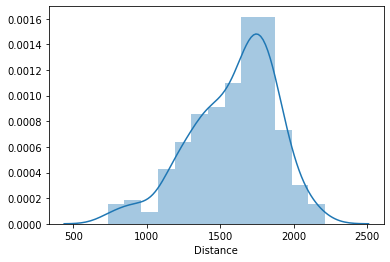

In [29]:
seattle_aclose = seattle_restaurants.groupby('Park')
park_dist=[]
park_dist=seattle_aclose['Distance'].mean();
sns.distplot(park_dist);
print(f"""There are {len(park_dist[park_dist<=1609.344])} parks less than a mile from restaurants, that's {len(park_dist[park_dist<=1609.344])/len(park_dist)*100}%""")
print(f"""There are {len(park_dist[park_dist<=804.672])} parks less than a 1/2 mile from restaurants, that's {len(park_dist[park_dist<=804.672])/len(park_dist)*100}%""")

In [30]:
#This is the list of the 3 parks which are less than a half mile from restaurants
nbrhoods_used = park_dist[park_dist<=804.672].index 
seattle_aclose_filtered = seattle_parks[seattle_parks.Name.isin(nbrhoods_used)]
seattle_dblaclose=seattle_aclose_filtered[['Name','lng','lat']].drop_duplicates()
print('The 3 parks which are less than a half mile from restaurants include:', *seattle_dblaclose['Name'], sep='\n- ')

The 3 parks which are less than a half mile from restaurants include:
- Cal Anderson Park and Bobby Morris Playfield
- Regrade Park
- Westlake Park


Of the 14 total parks with 15 or more amenities, there are 4 parks less than a mile from restaurants, that's 28.57142857142857%


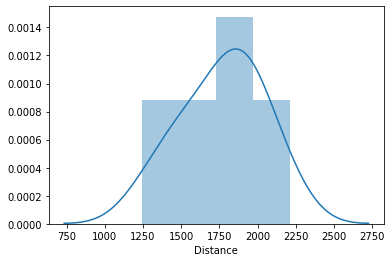

In [31]:
seattle_dist15 = seattle_restaurants15.groupby('Park')
filter15=seattle_restaurants15[['Park','ParkLongitude','ParkLatitude']].drop_duplicates()
park_dist15=[]
park_dist15=seattle_dist15['Distance'].mean();
sns.distplot(park_dist15);
print(f"""Of the {len(park_dist15)} total parks with 15 or more amenities, there are {len(park_dist15[park_dist15<=1609.344])} parks less than a mile from restaurants, that's {len(park_dist15[park_dist15<=1609.344])/len(park_dist15)*100}%""")


In [32]:

#This is the list of the 3 parks which are less than a half mile from restaurants
nbrhoods_used = park_dist15[park_dist15<=1609.344].index 
seattle_15close_filtered = seattle_parks[seattle_parks.Name.isin(nbrhoods_used)]
seattle_dblaclose15=seattle_15close_filtered[['Name','lng','lat']].drop_duplicates()
print('The 4 parks which have more than 15 amenities and within a mile of food are:', *seattle_dblaclose15['Name'], sep='\n- ')


The 4 parks which have more than 15 amenities and within a mile of food are:
- Warren G. Magnuson Park
- Woodland Park
- Magnolia Playfield
- Hiawatha Playfield


## Make a Color Coded map of the locations


In [33]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=11) # generate map centred around Queen Anne Neighborhood Hotel

# add a red circle marker to represent the Queen Anne Neighborhood
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Queen Anne Neighborhood',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the parks with food within 1/2 mile as yellow circle markers
for lat, lng, label in zip(seattle_dblaclose.lat, seattle_dblaclose.lng, seattle_dblaclose.Name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='purple',
        popup= label,
        fill= True,
        fill_color='purple',
        fill_opacity=0.6
    ).add_to(venues_map)

# add the parks with 15 or more amenities as blue circle markers
for lat, lng, label in zip(filter15.ParkLatitude, filter15.ParkLongitude, filter15.Park):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup= label,
        fill= True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# add the parks with 15 or more amenities and within 1 mile of food as green circle markers
for lat, lng, label in zip(seattle_dblaclose15.lat, seattle_dblaclose15.lng, seattle_dblaclose15.Name):
    folium.features.CircleMarker(
        [lat, lng],
        radius=10,
        color='green',
        popup=label,
        fill= True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)   

    
# display map
venues_map

#### For the three parks with the shortest walking distance to restaurants their cuisine includes both quick small snack locations like cafe's and bakeries, as well as more formal takeout options

In [34]:
num_top_venues = 5
for hood in seattle_dblaclose['Name']:
    print("----"+hood+"----")
    temp = seattle_grouped1[seattle_grouped1['Park'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)*100
    temp = temp.round({'freq': 0})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Cal Anderson Park and Bobby Morris Playfield----
                 venue  freq
0                 Café   7.0
1               Bakery   7.0
2   Italian Restaurant   6.0
3     Ramen Restaurant   5.0
4  American Restaurant   4.0


----Regrade Park----
                venue  freq
0      Breakfast Spot   8.0
1              Bakery   6.0
2  Seafood Restaurant   6.0
3  Italian Restaurant   6.0
4         Pizza Place   5.0


----Westlake Park----
                venue  freq
0      Breakfast Spot   7.0
1              Bakery   6.0
2  Italian Restaurant   5.0
3      Sandwich Place   5.0
4  Seafood Restaurant   5.0




#### For the four parks with the largest variety of amenitites and the shortest walking distance to restaurants their cuisine includes Pizza as well as some other take out options. Of them, Magnuson also offers some food trucks options.

In [35]:
num_top_venues = 5
for hood in seattle_dblaclose15['Name']:
    print("----"+hood+"----")
    temp = seattle_grouped1[seattle_grouped1['Park'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)*100
    temp = temp.round({'freq': 0})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Warren G. Magnuson Park----
                 venue  freq
0  American Restaurant  25.0
1           Food Truck  25.0
2                 Café  12.0
3          Pizza Place  12.0
4     Greek Restaurant  12.0


----Woodland Park----
                 venue  freq
0          Pizza Place  11.0
1         Burger Joint   5.0
2  Japanese Restaurant   5.0
3                 Café   5.0
4    Indian Restaurant   4.0


----Magnolia Playfield----
                 venue  freq
0       Sandwich Place  13.0
1          Pizza Place  13.0
2  Japanese Restaurant   9.0
3                 Café   6.0
4     Asian Restaurant   4.0


----Hiawatha Playfield----
                 venue  freq
0          Pizza Place  13.0
1   Mexican Restaurant   9.0
2   Italian Restaurant   5.0
3     Asian Restaurant   5.0
4  American Restaurant   5.0




## Results and Discussion. <a name="results"></a>
Our analysis shows that although there are a lot of parks spread throughout the Seattle metropolitan area, most are small parks with less than 15 amenities. 
As families will want to know of food options to help them select the park they visit, we pulled lists of restaurants around each park from Foursquare, then clustered them to identify potential park areas of interest.  There are a range of food options available, but there there are some areas in the city with some bias towards certain types of cuisine vs others. For example, the central southeast part of the city has more Vietnamese food options, while as you move to the far north, you get more pizza restaurant options. The preliminary segmentation was helpful to provide some general guidance to families searching for food options around their choice of park, but further analysis would be necessary to suss out deeper patterns, perhaps with street-level walkability indices as well to help decide on where to take their outdoor outing.

Further analysis broke into two different subtypes of families. For the families who don't want to walk very far from the park to find food, we filtered to 3 parks with less than 1/2 mile walking distance to restaurants.For such families, they might be better served to focus on the parks in central Seattle, near the Belltown and Capitol Hill neighborhoods. This correlates to a number of museums and attractions in the area, but during Covid, most of these are closed. As we move into later Phases of reopening, these parks might also offer additional venues, besides parks for a blend of indoor and outdoor activities. The types of restaurants tended included a blend of quick-snack and restaurant options, as expected for city-parks. 
For families looking for more options of things to do within the parks, the search radius was expanded to 1 mile around the parks. Since the parks with more amenities also tend to be larger, this is probably comparable distance from the perimeter of the park. There were 4 parks which met these criteria. They were a bit longer commute for families, to Green Lake, West Seattle, or up to Lake Washington. Most of the nearby restaurants were bigger-meal take out restaurants, and all had a lot of pizza options. 



## Conclusion. <a name="conclusion"></a>
The purpose of this project was to identify park locations around the Queen Anne neighborhood in order to aid a group of families in narrowing down the search for something to do to get outside, despite current restrictions. By calculating restaurant distances from Foursquare data we have first identified several options for families, including by type of food to eat after they finish their outing.  We found 3 options for those wanting a more casual outing in the city parks, and 4 options for those looking for more variety of activities.  This doesn't imply these are the only outdoor options, nor  does it take into account the relative walkability indices of the neighborhoods arounds the parks. Recommended parks should therefore be considered only as a starting point for more detailed analysis, perhaps also considering the bike and running trails around the city and including criteria for types of activities suitable to different age children and family activity levels. 
